In [1]:
# Load library
# Data handling
import math, warnings,nltk
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

# Text cleaning
import re
import string
from nltk.corpus import stopwords
!pip install emoji openpyxl
from emoji import demojize
from google.colab import files

# Text vectorization and embedding
from sentence_transformers import SentenceTransformer

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering algorithms
from sklearn.cluster import KMeans

# Evaluation
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from collections import Counter, defaultdict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 14.1 MB/s eta 0:00:00


In [2]:
#Pre configuration
PATH = "Tweets.xlsx"
COL_TEXT = "text"
COL_LABEL = "airline_sentiment"  # used only for verification
COL_CONF  = "sentiment_confidence"  # used for “low confidence” check

N_CLUSTERS = 3
RANDOM_STATE = 42
BERT_MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"


# Dimensionality reduction for clustering speed
USE_UMAP_FOR_EMB = True  # set False to cluster directly on embeddings
UMAP_N_COMPONENTS = 50

# Visualizations
DO_TSNE_VIS = True  # set True for a pretty 2D map

In [3]:
# Load dataset
uploaded = files.upload()  # Choose Excel file from computer

df = pd.read_excel(next(iter(uploaded)))  # Load the uploaded file
df.head()
data = pd.read_excel("Tweets.xlsx")
print(df.head())

# Peek at structure
print(data.head())
print(data.columns)

Saving Tweets.xlsx to Tweets.xlsx
  airline_sentiment  ...                                               text
0           neutral  ...                @VirginAmerica What @dhepburn said.
1          positive  ...  @VirginAmerica plus you've added commercials t...
2           neutral  ...  @VirginAmerica I didn't today... Must mean I n...
3          negative  ...  @VirginAmerica it's really aggressive to blast...
4          negative  ...  @VirginAmerica and it's a really big bad thing...

[5 rows x 3 columns]
  airline_sentiment  ...                                               text
0           neutral  ...                @VirginAmerica What @dhepburn said.
1          positive  ...  @VirginAmerica plus you've added commercials t...
2           neutral  ...  @VirginAmerica I didn't today... Must mean I n...
3          negative  ...  @VirginAmerica it's really aggressive to blast...
4          negative  ...  @VirginAmerica and it's a really big bad thing...

[5 rows x 3 columns]
Index(['ai

In [4]:
#Check if necessary columns are in the file
df = pd.read_excel(PATH)

assert COL_TEXT in df.columns, f"'{COL_TEXT}' column not found. Available: {df.columns.tolist()}"
if COL_LABEL not in df.columns:
    print(f"Note: '{COL_LABEL}' not found — evaluation will skip label-based scores.")
if COL_CONF not in df.columns:
    print(f"Note: '{COL_CONF}' not found — “low-confidence miscluster” analysis will be skipped.")

print(df.head(3))
print("Rows:", len(df))

  airline_sentiment  ...                                               text
0           neutral  ...                @VirginAmerica What @dhepburn said.
1          positive  ...  @VirginAmerica plus you've added commercials t...
2           neutral  ...  @VirginAmerica I didn't today... Must mean I n...

[3 rows x 3 columns]
Rows: 14639


In [5]:
# Download stopwords
nltk.download('stopwords', quiet=True)

# Stopwords
STOPWORDS = set(stopwords.words('english')).union({"rt", "amp", "u", "im", "us"})

# Regex patterns
URL_RE = re.compile(r"http\S+|www\.\S+") # remove URLs
AT_RE  = re.compile(r"@\w+") # remove mentions
WS_RE  = re.compile(r"\s+") # remove extra spaces

# Text emoticon mapping
EMOTICON_MAP = {
    "</3": "broken_heart", "<3": "love", ":'-)": "crying_with_joy", ":'(": "crying",
    ":-)": "smile", ":)": "smile", ":-d": "laugh", ":d": "laugh", "=d": "laugh",
    "xd": "laughing_hard", ";-)": "wink", ";)": "wink", ":-p": "playful", ":p": "playful",
    ";p": "playful", ":-o": "surprised", ":o": "surprised", ":-(": "sad", ":(": "sad",
    ":-/": "uneasy", ":/": "uneasy", ":-|": "neutral", ":|": "neutral", "b-)": "cool",
    "b)": "cool", "o_o": "shock", "o.o": "shock", "-_-": "annoyed", "^_^": "happy",
    "t_t": "crying", ":3": "cute_face", "d:": "horror", "d8": "shock"
}

# Emoticon regex (safe, fast)
EMOTICON_RE = re.compile(
    "(" + "|".join(re.escape(e) for e in sorted(EMOTICON_MAP, key=len, reverse=True)) + ")",
    re.IGNORECASE
)

#Convert text-based emoticons to descriptive words
def convert_emoticons(text: str) -> str:
    def _replacer(m):
        token = m.group(0).lower()
        return " " + EMOTICON_MAP.get(token, "") + " "
    return EMOTICON_RE.sub(_replacer, text)

# Cleaner function
def clean_text(text):
    t = str(text).lower() # lowercase
    t = demojize(t) # 😊 -> :smiling_face:
    t = convert_emoticons(t) # :) -> smile
    t = t.replace(":", " ").replace("_", " ")  # make demojized words readable
    t = URL_RE.sub("", t) # remove URLs
    t = AT_RE.sub("", t) # remove mentions
    t = t.replace("#", "") # drop "#" but keep the word
    t = re.sub(r"\d+", " ", t) # remove numbers
    t = re.sub(r"[^\x00-\x7F]+", " ", t) # strip any remaining non-ASCII
    t = WS_RE.sub(" ", t).strip() # normalize spaces
    tokens = [w for w in t.split() if w not in STOPWORDS]
    return " ".join(tokens)

# Apply cleaning
COL_TEXT = "text"
df = df.drop_duplicates(subset=[COL_TEXT]).copy() #remove duplicate
df["clean_text"] = df[COL_TEXT].fillna("").apply(clean_text)
df = df[df["clean_text"].str.len() > 0].reset_index(drop=True)

print(f"After cleaning, rows: {len(df)}")
print(df.head())

# Export to Excel
output_path = "cleaned_text.xlsx"
df.to_excel(output_path, index=False)

After cleaning, rows: 14419
  airline_sentiment  ...                                         clean_text
0           neutral  ...                                              said.
1          positive  ...        plus added commercials experience... tacky.
2           neutral  ...         today... must mean need take another trip!
3          negative  ...  really aggressive blast obnoxious "entertainme...
4          negative  ...                               really big bad thing

[5 rows x 4 columns]


In [9]:
# BERT/SentenceTransformer embeddings
model = SentenceTransformer(BERT_MODEL)
embeddings = model.encode(df["clean_text"].tolist(), show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
print("Embeddings shape:", embeddings.shape)

Batches:   0%|          | 0/451 [00:00<?, ?it/s]

Embeddings shape: (14419, 768)


In [10]:
#Use Umap to do dimension reduction for clustering
if USE_UMAP_FOR_EMB:
    reducer = umap.UMAP(n_components=UMAP_N_COMPONENTS, random_state=RANDOM_STATE, metric="cosine")
    X = reducer.fit_transform(embeddings)
    print("UMAP shape:", X.shape)
else:
    X = embeddings

UMAP shape: (14419, 50)


In [11]:
# Clustering
results = {}

# KMeans
kmeans = KMeans(n_clusters=3, n_init="auto", random_state=RANDOM_STATE)
labels_km = kmeans.fit_predict(X)
results["kmeans"] = labels_km

In [12]:
# Unsupervised metrics
def safe_silhouette(X, labels):
    uniq = set(labels)
    if len(uniq) < 2: return np.nan
    if uniq == {-1}:  return np.nan
    try:
        return silhouette_score(X, labels, metric="cosine")
    except:
        return np.nan

for name, pred in results.items():
    sil = safe_silhouette(X, pred)
    print(f"[{name}] silhouette : {sil:.4f}" if not math.isnan(sil) else f"[{name}] silhouette: N/A")

[kmeans] silhouette : 0.7094


In [14]:
# Purity, confusion, and low-confidence score analysis
def cluster_purity(pred_labels, given_labels):
    df_tmp = pd.DataFrame({"pred": pred_labels, "given": given_labels})
    total = len(df_tmp)
    correct = 0
    for c, grp in df_tmp.groupby("pred"):
        if len(grp) == 0: continue
        correct += grp["given"].value_counts().max()
    return correct / total

if COL_LABEL in df.columns:
    for name, pred in results.items():
        if len(set(pred)) < 2 or (set(pred) == {-1}):
            print(f"[{name}] Purity skipped (degenerate clustering).")
            continue

        # Purity
        purity = cluster_purity(pred, df[COL_LABEL].values)
        print(f"[{name}] Cluster Purity: {purity:.4f}")

        # Confusion-like table (cluster vs given)
        tab = pd.crosstab(pd.Series(pred, name="cluster"), pd.Series(df[COL_LABEL], name="given"))
        print(f"\n[{name}] Cluster vs Given:\n", tab)

        # Build per-cluster majority label
        # cluster -> majority given label
        maj = tab.idxmax(axis=1).to_dict()

        is_mis = []
        for i, c in enumerate(pred):
            g = df.loc[i, COL_LABEL]
            is_mis.append(g != maj.get(c, g))
        df[f"mis_{name}"] = is_mis

        if COL_CONF in df.columns:
            mis_conf = df.loc[df[f"mis_{name}"], COL_CONF].dropna()
            hit_conf = df.loc[~df[f"mis_{name}"], COL_CONF].dropna()
            if len(mis_conf) and len(hit_conf):
                print(f"\n[{name}] Mean confidence (correct): {hit_conf.mean():.3f}")
                print(f"[{name}] Mean confidence (misclustered): {mis_conf.mean():.3f}")
                print(f"[{name}] Do misclustered tweets have lower confidence? ",
                      "Likely yes." if mis_conf.mean() < hit_conf.mean() else "Not obvious.")
        print("-"*60)


[kmeans] Cluster Purity: 0.7244

[kmeans] Cluster vs Given:
 given    negative  neutral  positive
cluster                             
0             531      516      1898
1            5818      385        59
2            2729     2151       332

[kmeans] Mean confidence (correct): 0.932
[kmeans] Mean confidence (misclustered): 0.816
[kmeans] Do misclustered tweets have lower confidence?  Likely yes.
------------------------------------------------------------


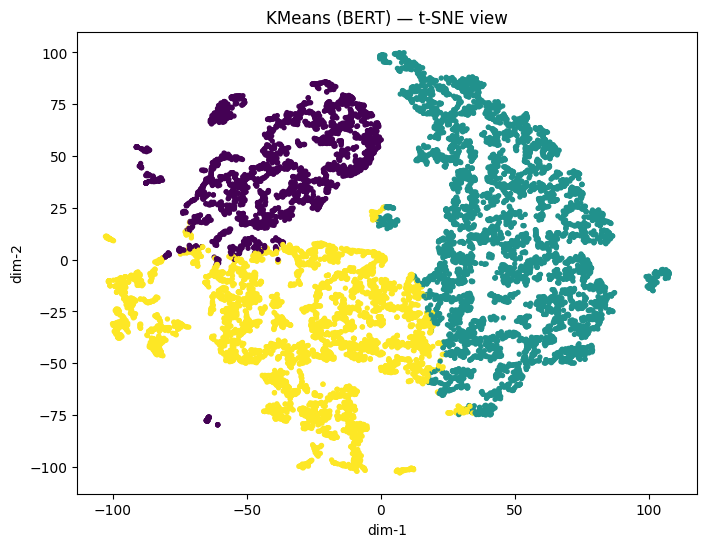

In [18]:
# 2D Visualization
def plot_2d(points2d, labels, title):
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(points2d[:,0], points2d[:,1], c=labels, s=8)
    plt.title(title)
    plt.xlabel("dim-1"); plt.ylabel("dim-2")
    plt.show()

# Choose a clustering to visualize
pred = results["kmeans"]

if DO_TSNE_VIS:
    pca = PCA(n_components=min(50, X.shape[1]), random_state=RANDOM_STATE)
    X50 = pca.fit_transform(X)
    tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=RANDOM_STATE)
    X2 = tsne.fit_transform(X50)
    plot_2d(X2, pred, "KMeans (BERT) — t-SNE view")

else:
    um2 = umap.UMAP(n_components=2, random_state=RANDOM_STATE, metric="cosine")
    X2 = um2.fit_transform(X)
    plot_2d(X2, pred, "KMeans (BERT) — UMAP 2D view")

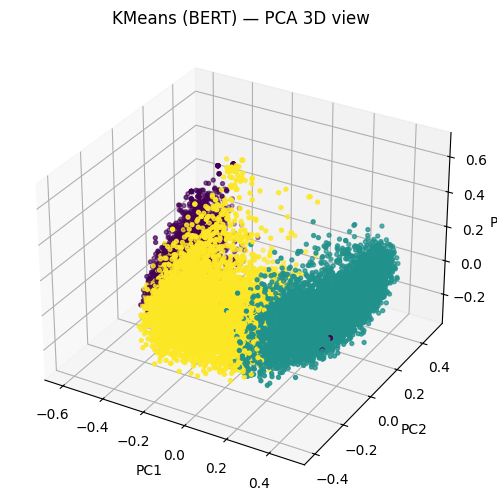

In [19]:
pca3 = PCA(n_components=3, random_state=RANDOM_STATE)
X3_pca = pca3.fit_transform(embeddings)

pred = results["kmeans"]

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X3_pca[:, 0], X3_pca[:, 1], X3_pca[:, 2], c=pred, s=8)
ax.set_title("KMeans (BERT) — PCA 3D view")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
plt.show()
